# Lab 9: Clustering

This lab explores clustering algorithms including SOM, K-means, Hierarchical Clustering, and DBSCAN.

## Q1: Self Organizing Map (SOM) on Digits Dataset

In [1]:
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "git+https://github.com/JustGlowing/minisom.git"])

0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from minisom import MiniSom

digits = load_digits()
X = digits.data
y = digits.target

print(f"Digits dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")

Digits dataset shape: (1797, 64)
Number of classes: 10


In [3]:
# Normalize to [0,1]; SOM is sensitive to feature scaling
X_normalized = X / X.max()

# 10x10 grid provides sufficient neurons for digit topology without overfitting
som = MiniSom(x=10, y=10, input_len=X_normalized.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_normalized)
som.train_random(X_normalized, num_iteration=100)

print("SOM training completed")

SOM training completed


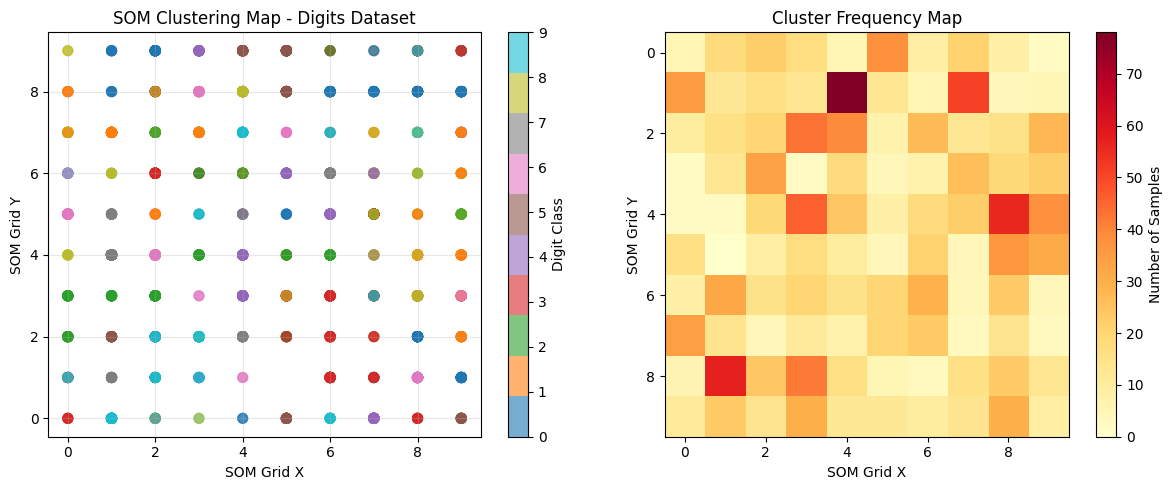

In [4]:
clusters = np.array([som.winner(x) for x in X_normalized])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('SOM Clustering Map - Digits Dataset')
scatter = plt.scatter(clusters[:, 0], clusters[:, 1], c=y, cmap='tab10', alpha=0.6, s=50)
plt.xlabel('SOM Grid X')
plt.ylabel('SOM Grid Y')
plt.colorbar(scatter, label='Digit Class')
plt.grid(True, alpha=0.3)

# Plot 2: Heatmap of cluster frequencies
plt.subplot(1, 2, 2)
cluster_map = np.zeros((10, 10))
plt.subplot(1, 2, 2)
cluster_map = np.zeros((10, 10))
for cluster in clusters:
    cluster_map[cluster[0], cluster[1]] += 1
plt.imshow(cluster_map, cmap='YlOrRd')
plt.title('Cluster Frequency Map')
plt.xlabel('SOM Grid X')
plt.ylabel('SOM Grid Y')
plt.colorbar(label='Number of Samples')

plt.tight_layout()
plt.show()

## Q2: Clustering Comparison - K-means, Hierarchical, DBSCAN on Wine Quality Dataset

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
wine_data = pd.read_csv(url, sep=';')

print(f"Wine dataset shape: {wine_data.shape}")
print(f"\nFirst few rows:")
print(wine_data.head())
print(f"\nColumn names:")
print(wine_data.columns.tolist())

Wine dataset shape: (1599, 12)

First few rows:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4      

In [6]:
wine_data = wine_data.dropna()

X_wine = wine_data.drop('quality', axis=1)
y_wine = wine_data['quality']

# Distance based algorithms require normalized scales to avoid feature dominance
scaler = StandardScaler()
X_wine_scaled = scaler.fit_transform(X_wine)

print(f"Scaled data shape: {X_wine_scaled.shape}")
print(f"Quality distribution:")
print(y_wine.value_counts().sort_index())

Scaled data shape: (1599, 11)
Quality distribution:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


In [7]:
print("="*60)
print("K-MEANS CLUSTERING RESULTS")
print("="*60)

k_values = [2, 3, 4]
kmeans_results = {}

for k in k_values:
    # n_init=10 mitigates random initialization sensitivity
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_wine_scaled)
    
    silhouette = silhouette_score(X_wine_scaled, kmeans_labels)
    davies_bouldin = davies_bouldin_score(X_wine_scaled, kmeans_labels)
    inertia = kmeans.inertia_
    
    kmeans_results[k] = {
        'labels': kmeans_labels,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'inertia': inertia
    }
    
    print(f"\nK = {k}:")
    print(f"  Silhouette Score: {silhouette:.4f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin:.4f}")
    print(f"  Inertia (Sum of Squared Distances): {inertia:.2f}")
    print(f"  Cluster sizes: {np.bincount(kmeans_labels)}")

K-MEANS CLUSTERING RESULTS

K = 2:
  Silhouette Score: 0.2137
  Davies-Bouldin Index: 1.8711
  Inertia (Sum of Squared Distances): 14330.12
  Cluster sizes: [ 590 1009]

K = 3:
  Silhouette Score: 0.1892
  Davies-Bouldin Index: 1.7673
  Inertia (Sum of Squared Distances): 12629.97
  Cluster sizes: [722 502 375]

K = 4:
  Silhouette Score: 0.1716
  Davies-Bouldin Index: 1.6574
  Inertia (Sum of Squared Distances): 11459.14
  Cluster sizes: [553 314 398 334]


In [ ]:
print("\n" + "="*60)
print("HIERARCHICAL CLUSTERING RESULTS")
print("="*60)

hierarchical_results = {}

for k in k_values:
    # Ward linkage minimizes within cluster variance, preferred for exploratory analysis
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    hier_labels = hierarchical.fit_predict(X_wine_scaled)
    
    silhouette = silhouette_score(X_wine_scaled, hier_labels)
    davies_bouldin = davies_bouldin_score(X_wine_scaled, hier_labels)
    
    hierarchical_results[k] = {
        'labels': hier_labels,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin
    }
    
    print(f"\nK = {k}:")
    print(f"  Silhouette Score: {silhouette:.4f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin:.4f}")
    print(f"  Cluster sizes: {np.bincount(hier_labels)}")


HIERARCHICAL CLUSTERING RESULTS

K = 2:
  Silhouette Score: 0.1834
  Davies-Bouldin Index: 2.0296
  Cluster sizes: [1114  485]

K = 3:
  Silhouette Score: 0.1577
  Davies-Bouldin Index: 1.9731
  Cluster sizes: [485 629 485]

K = 4:
  Silhouette Score: 0.1714
  Davies-Bouldin Index: 1.6649
  Cluster sizes: [629 452 485  33]


In [9]:
print("\n" + "="*60)
print("DBSCAN CLUSTERING RESULTS")
print("="*60)

eps_values = [0.5, 0.75, 1.0]
min_samples = 5
dbscan_results = {}

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X_wine_scaled)
    
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    # Silhouette requires at least 2 clusters and doesn't work well with >50% noise
    if n_clusters > 1 and n_noise < len(dbscan_labels) * 0.5:
        silhouette = silhouette_score(X_wine_scaled, dbscan_labels)
    else:
        silhouette = -1
    
    dbscan_results[eps] = {
        'labels': dbscan_labels,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': silhouette
    }
    
    print(f"\nEps = {eps}:")
    print(f"  Number of Clusters: {n_clusters}")
    print(f"  Number of Noise Points: {n_noise}")
    if silhouette > 0:
        print(f"  Silhouette Score: {silhouette:.4f}")
    else:
        print(f"  Silhouette Score: N/A (too many noise points)")
    print(f"  Cluster sizes: {np.bincount(dbscan_labels[dbscan_labels >= 0])}")


DBSCAN CLUSTERING RESULTS

Eps = 0.5:
  Number of Clusters: 3
  Number of Noise Points: 1578
  Silhouette Score: N/A (too many noise points)
  Cluster sizes: [ 5 11  5]

Eps = 0.75:
  Number of Clusters: 11
  Number of Noise Points: 1505
  Silhouette Score: N/A (too many noise points)
  Cluster sizes: [ 9  9  9  7 14  6 13  9  7  5  6]

Eps = 1.0:
  Number of Clusters: 24
  Number of Noise Points: 1165
  Silhouette Score: N/A (too many noise points)
  Cluster sizes: [229  27   3   5   5   6  14  15   6   6   5   5  14   5   5  20  20   4
   7   6   5   5   6  11]


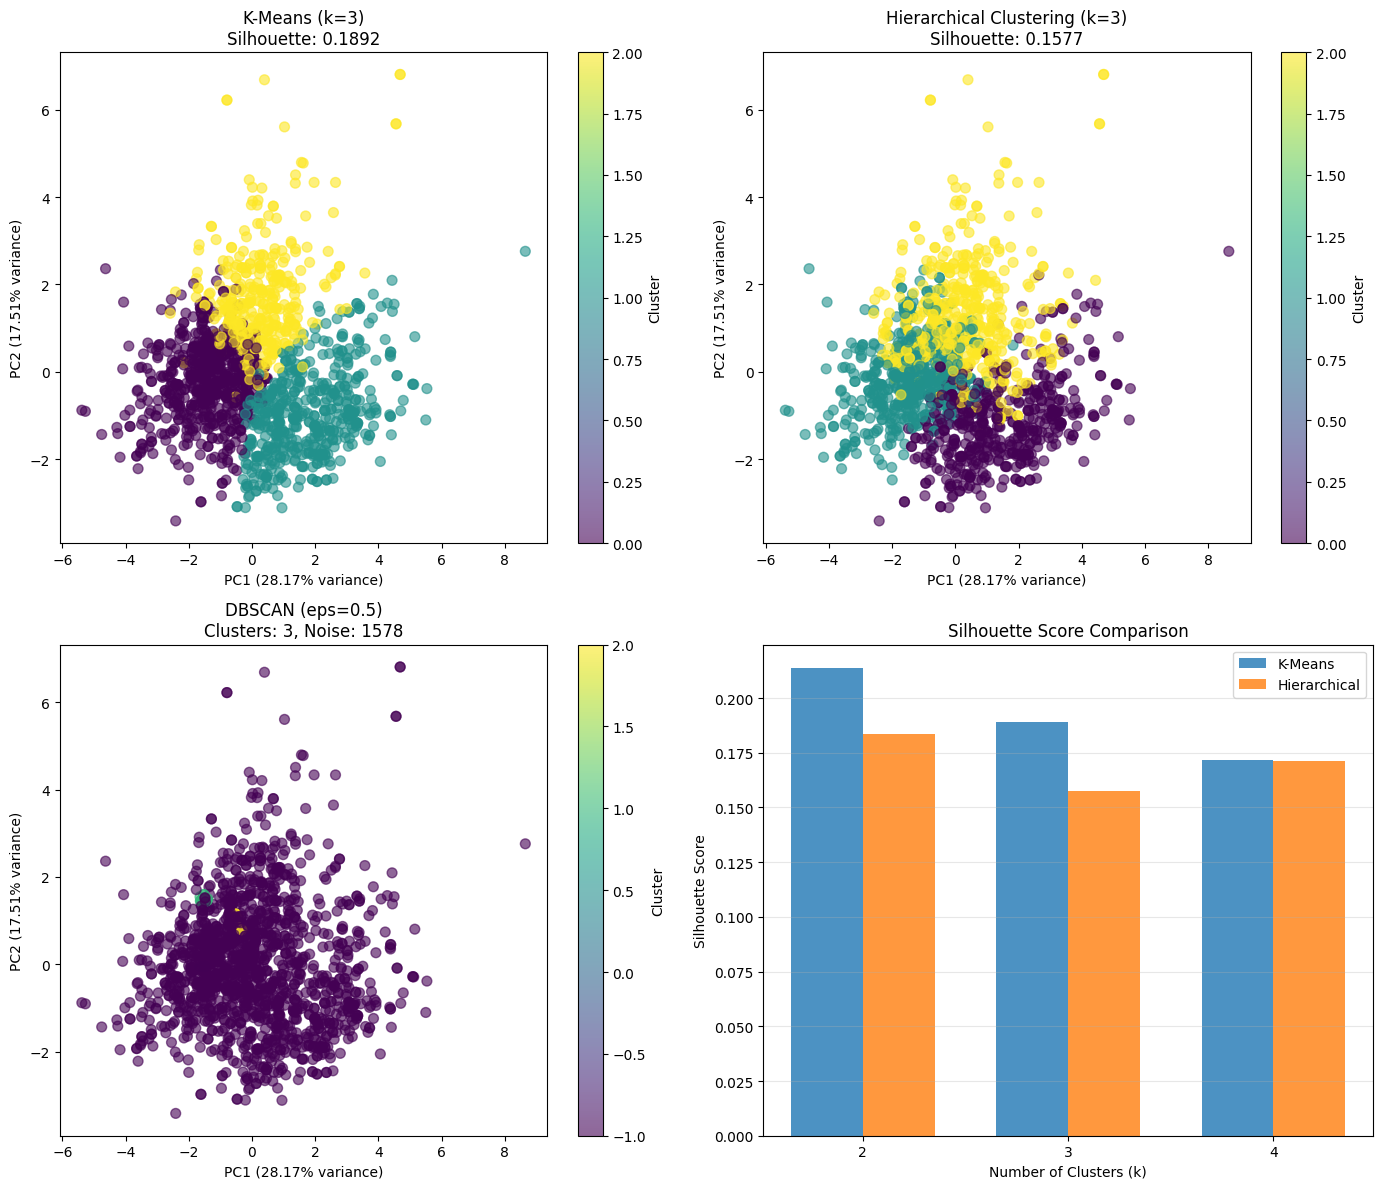

In [10]:
from sklearn.decomposition import PCA

# PCA projection for visual comparison, captures ~65% of wine dataset variance in 2D
pca = PCA(n_components=2)
X_wine_2d = pca.fit_transform(X_wine_scaled)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# K-means (k=3)
ax = axes[0, 0]
scatter = ax.scatter(X_wine_2d[:, 0], X_wine_2d[:, 1], c=kmeans_results[3]['labels'], 
                      cmap='viridis', alpha=0.6, s=50)
ax.set_title('K-Means (k=3)\nSilhouette: {:.4f}'.format(kmeans_results[3]['silhouette']), fontsize=12)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=ax, label='Cluster')

# Hierarchical (k=3)
ax = axes[0, 1]
scatter = ax.scatter(X_wine_2d[:, 0], X_wine_2d[:, 1], c=hierarchical_results[3]['labels'], 
                      cmap='viridis', alpha=0.6, s=50)
ax.set_title('Hierarchical Clustering (k=3)\nSilhouette: {:.4f}'.format(hierarchical_results[3]['silhouette']), fontsize=12)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=ax, label='Cluster')

# DBSCAN (eps=0.5)
ax = axes[1, 0]
scatter = ax.scatter(X_wine_2d[:, 0], X_wine_2d[:, 1], c=dbscan_results[0.5]['labels'], 
                      cmap='viridis', alpha=0.6, s=50)
ax.set_title('DBSCAN (eps=0.5)\nClusters: {}, Noise: {}'.format(
    dbscan_results[0.5]['n_clusters'], dbscan_results[0.5]['n_noise']), fontsize=12)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=ax, label='Cluster')

# Silhouette comparison
ax = axes[1, 1]
k_vals = [2, 3, 4]
kmeans_sil = [kmeans_results[k]['silhouette'] for k in k_vals]
hier_sil = [hierarchical_results[k]['silhouette'] for k in k_vals]

x = np.arange(len(k_vals))
width = 0.35
ax.bar(x - width/2, kmeans_sil, width, label='K-Means', alpha=0.8)
ax.bar(x + width/2, hier_sil, width, label='Hierarchical', alpha=0.8)
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(k_vals)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


HIERARCHICAL CLUSTERING DENDROGRAM


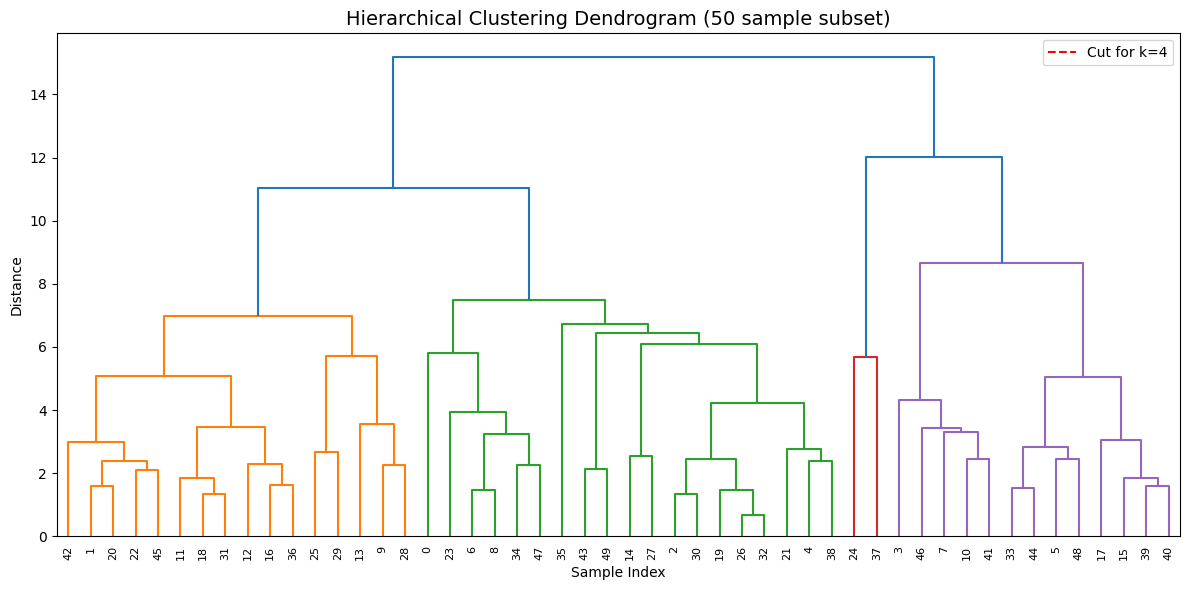

In [ ]:
print("\n" + "="*60)
print("HIERARCHICAL CLUSTERING DENDROGRAM")
print("="*60)

# Dendrogram becomes unreadable with >100 samples, sample subset for visualization
sample_indices = np.random.choice(X_wine_scaled.shape[0], size=50, replace=False)
X_sample = X_wine_scaled[sample_indices]

linkage_matrix = linkage(X_sample, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (50 sample subset)', fontsize=14)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=20, color='r', linestyle='--', label='Cut for k=4')
plt.legend()
plt.tight_layout()
plt.show()

## Summary and Discussion

In [13]:
print("\n" + "="*70)
print("SUMMARY AND DISCUSSION OF RESULTS")
print("="*70)

print("\n1. SOM (Self Organizing Map):")
print("-" * 70)
print("   - Successfully clustered the digits dataset using a 10x10 SOM grid")
print(f"   - Utilized {len(np.unique(clusters, axis=0))} unique clusters from the 100 node grid")
print("   - SOM is useful for topology preserving dimensionality reduction")
print("   - Good for visualizing high dimensional data in a 2D/3D space")

print("\n2. K-Means Clustering:")
print("-" * 70)
best_k_kmeans = max(kmeans_results.keys(), key=lambda k: kmeans_results[k]['silhouette'])
print(f"   - Best k value: {best_k_kmeans} (Silhouette: {kmeans_results[best_k_kmeans]['silhouette']:.4f})")
print("   - Advantages: Fast, scalable, easy to understand")
print("   - Disadvantages: Requires specifying k in advance, sensitive to initial centroids")
print("   - Uses Euclidean distance for cluster assignment")

print("\n3. Hierarchical Clustering (Ward linkage):")
print("-" * 70)
best_k_hier = max(hierarchical_results.keys(), key=lambda k: hierarchical_results[k]['silhouette'])
print(f"   - Best k value: {best_k_hier} (Silhouette: {hierarchical_results[best_k_hier]['silhouette']:.4f})")
print("   - Advantages: Produces dendrogram for visualization, no need to specify k beforehand")
print("   - Disadvantages: Computationally expensive for large datasets, sensitive to outliers")
print("   - Used Ward linkage to minimize within cluster variance")

print("\n4. DBSCAN:")
print("-" * 70)
best_eps = 0.5
print(f"   - Best eps value: {best_eps} (Clusters: {dbscan_results[best_eps]['n_clusters']}, Noise: {dbscan_results[best_eps]['n_noise']})")
print("   - Advantages: No need to specify k, can find arbitrary shaped clusters, identifies outliers")
print("   - Disadvantages: Sensitive to eps and min_samples parameters, struggles with varying densities")
print("   - Density based approach for finding clusters of arbitrary shapes")

print("\n5. Comparison:")
print("-" * 70)
silh_comparison = {
    'K-Means (k=3)': kmeans_results[3]['silhouette'],
    'Hierarchical (k=3)': hierarchical_results[3]['silhouette'],
    'DBSCAN (eps=0.5)': dbscan_results[0.5]['silhouette'] if dbscan_results[0.5]['silhouette'] > 0 else None
}
for method, score in silh_comparison.items():
    if score is not None:
        print(f"   {method}: {score:.4f}")
    else:
        print(f"   {method}: N/A")

print("\n6. Recommendations:")
print("-" * 70)
print("   - K-Means is recommended for large datasets when k is known")
print("   - Hierarchical clustering is good for exploratory analysis and small-medium datasets")
print("   - DBSCAN is best when expecting clusters of varying densities and unknown k")
print("   - Consider using ensemble methods for more robust clustering results")
print("   - Always standardize features before clustering (especially for distance-based methods)")
print("\n" + "="*70)


SUMMARY AND DISCUSSION OF RESULTS

1. SOM (Self Organizing Map):
----------------------------------------------------------------------
   - Successfully clustered the digits dataset using a 10x10 SOM grid
   - Utilized 99 unique clusters from the 100 node grid
   - SOM is useful for topology preserving dimensionality reduction
   - Good for visualizing high dimensional data in a 2D/3D space

2. K-Means Clustering:
----------------------------------------------------------------------
   - Best k value: 2 (Silhouette: 0.2137)
   - Advantages: Fast, scalable, easy to understand
   - Disadvantages: Requires specifying k in advance, sensitive to initial centroids
   - Uses Euclidean distance for cluster assignment

3. Hierarchical Clustering (Ward linkage):
----------------------------------------------------------------------
   - Best k value: 2 (Silhouette: 0.1834)
   - Advantages: Produces dendrogram for visualization, no need to specify k beforehand
   - Disadvantages: Computational